# De Novo Generation

Lead by Emmanuel Bengio & Julien Roy

Previously on during the summer school, we have seen how to take existing molecules, make predictions about them, filter them, and model them physically.

In Lab 3, we will take a look at various methods that allow us to propose new molecules while optimizing their properties. This optimization is done "from scratch", **de novo**, rather than by searching through an existing list of compounds. This means that we need to develop algorithms that can modify or propose molecules while making sure that these molecules are "reasonable".

## Installing python libraries

First a few boring steps...

**On Google Colab**

Start this first cell on colab to get things installed while reading the rest of the notebook. (If you get a message about `pydevd_plugins` you can safely ignore it)

**From scratch**

The following cell of `pip` will also install `torch==2.3.0+cu121`. If your local cuda version doesn't match, make sure to change that, and to change the `pyg.org/...` link on the second line to point to the same `torch` version. If you already have `torch` installed and would rather not change it, you can similarly edit the link to match your torch version. Success not guaranteed ;)

In [1]:
try:
  import torch
  assert torch.__version__.startswith('2.3') and 'cu121' in torch.__version__
except:
  print("We're probably not in collab and couldn't find the right torch.")
  !pip install torch==2.3.0 --index-url https://download.pytorch.org/whl/cu121

!pip install medchem mol_ga safe-mol torch_geometric torch_sparse torch_scatter rdkit gitpython omegaconf wandb --find-links https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install --no-deps git+https://github.com/recursionpharma/gflownet.git@f106cde
# !pip install botorch gpytorch linear_operator jaxtyping pyro-ppl --no-deps

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
  Cloning https://github.com/recursionpharma/gflownet.git (to revision f106cde) to /tmp/pip-req-build-s7jy6wdx
  Running command git clone --filter=blob:none --quiet https://github.com/recursionpharma/gflownet.git /tmp/pip-req-build-s7jy6wdx
  Running command git checkout -q f106cde
  Resolved https://github.com/recursionpharma/gflownet.git to commit f106cde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Part 1: Setting up and exploring `medchem` and `graph-ga`

First, we need to define _what_ we'll be optimizing. Let's load the model that we trained in prior labs.

In [2]:
# TODO: Replace this with your own model!
import torch
import torch.nn as nn
import io, requests
from rdkit import Chem

class EGFRPredictor:
  def __init__(self):
    r = io.BytesIO(requests.get("https://storage.googleapis.com/emmanuel-data/models/egfr_linear.pt").content)
    state_dict = torch.load(r)
    self.linear = nn.Linear(2048, 1)
    self.linear.load_state_dict(state_dict)
  def predict(self, mols):
    if isinstance(mols[0], str):
      mols = [Chem.MolFromSmiles(i) for i in mols]
    fps = torch.tensor([Chem.RDKFingerprint(i) for i in mols]).float()
    with torch.no_grad():
      return self.linear(fps)[:, 0]

predictor = EGFRPredictor()

Let's instanciate some molecules to use as examples

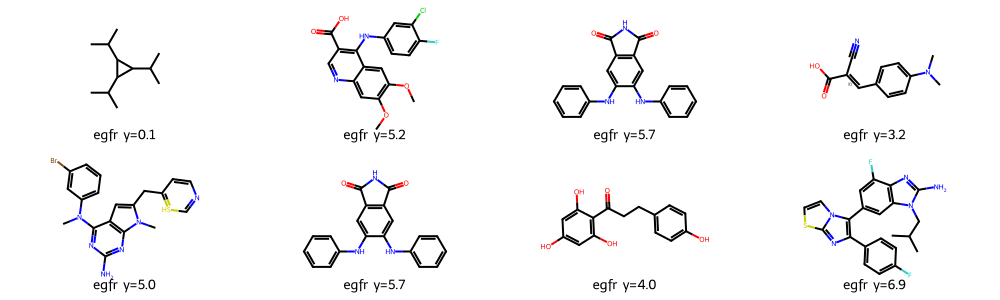

In [3]:
import datamol as dm
some_mols = [Chem.MolFromSmiles(i) for i in
 ['CC(C)C1C(C(C)C)C1C(C)C',
  'C1(=C(OC)C=C2C(=C1)C(NC=3C=CC(=C(C3)Cl)F)=C(C=N2)C(=O)O)OC',
  'C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1',
  'C(\\C(=O)O)(=C/C=1C=CC(=CC1)N(C)C)/C#N',
  'C=1C(Br)=CC=CC1N(C2=NC(N)=NC=3N(C(=CC23)CC4=SC=NC=C4)C)C',
  'C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1',
  'C1=C(C=C(C(=C1O)C(CCC=2C=CC(=CC2)O)=O)O)O',
  'S1C=2N(C(C=3C=C4N(C(=NC4=C(F)C3)N)CC(C)C)=C(N2)C5=CC=C(F)C=C5)C=C1']
]
ys = predictor.predict(some_mols)
dm.to_image(some_mols, legends=[f'egfr y={i:.1f}' for i in ys], n_cols=4, mol_size=(250, 150))

This predictor will help us guide our search, even if only approximately. We'd like to produce molecules that strike the highest possible score.

Aside from producing molecules with high binding affinity, it would be good to also use our knowledge of chemistry to try and generate "reasonable molecules". But what makes a molecule reasonable? This is an almost unanswerable question, but typically we want the molecule to be stable, to be synthesizable, to not be toxic, and to go through the body in a sensible way (often referred to with this combination of letters: (`ADME[T]`).

Unfortunately, predicting those properties is quite hard, so we'll have to use some simpler heuristics. For the purposes of this lab, we will recruit the help of the [`medchem`](https://github.com/datamol-io/medchem) library.

Let's try to augment our score predictor with some simple filtering. For example, we can use some pattern detectors to look for [PAINS](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds):

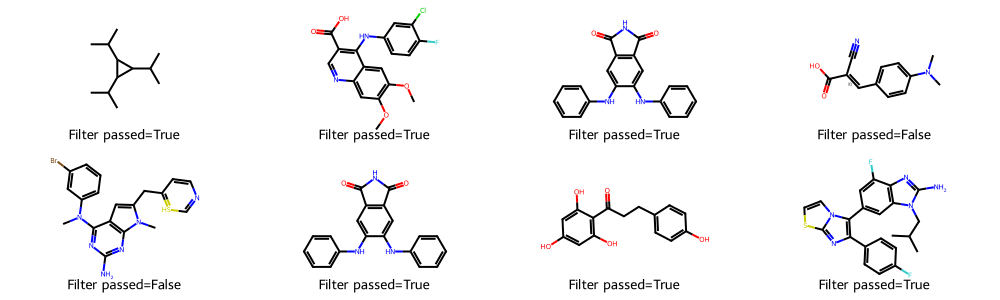

In [4]:
import medchem as mc
accepted = mc.functional.alert_filter(some_mols, ['PAINS'])
legends = [f"Filter passed={o}" for o in accepted]
dm.to_image(some_mols, legends=legends, n_cols=4, mol_size=(250, 150))

Or see if the molecules pass [Lipinski's rule-of-five](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five):

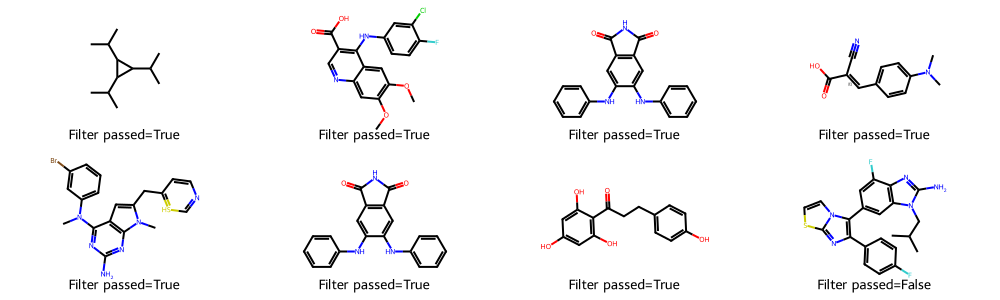

In [5]:
accepted = [mc.rules.basic_rules.rule_of_five(i) for i in some_mols]
legends = [f"Filter passed={o}" for o in accepted]
dm.to_image(some_mols, legends=legends, n_cols=4, mol_size=(250, 150))

There's a whole set of "rules" and filters [implemented for us in medchem](https://medchem-docs.datamol.io/stable/tutorials/Basic_Concepts.html), but it's important to always keep in mind that these are ultimately just guesses as to what makes a good molecule, rather than hard rules. Many real drugs do not respect most of these rules!

Let's use our predictor and some of these heuristics to create a score function.

In [6]:
class EGFRScore:
  def __init__(self, predictor):
    self.predictor = predictor
  def score(self, mols):
    # TODO: incorporate more medchem heuristics
    ys = self.predictor.predict(mols)
    ro5 = 1 - torch.tensor([mc.rules.basic_rules.rule_of_five(i) for i in mols]).float()
    pains = 1 - torch.tensor(mc.functional.alert_filter(mols, ['PAINS'])).float()
    return ys / 2 ** (ro5 + pains)  # Divide the score by 2 every time a filter is unhappy

In [7]:
scorer = EGFRScore(predictor)

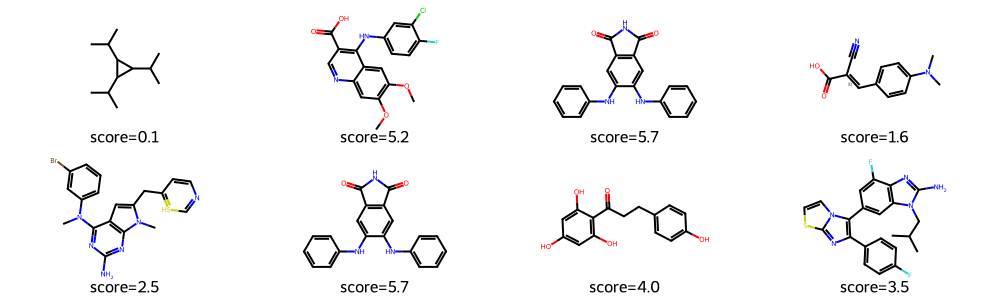

In [8]:
scores = scorer.score(some_mols)
dm.to_image(some_mols, legends=[f'score={i:.1f}' for i in scores], n_cols=4, mol_size=(250, 150))

## Generate-and-filter

We now have a predictor that scores molecular candidates both on their expected binding affinity, and heuristic-based drug-likeness. We are ready to generate new molecules that maximise these properties.

The first approach we will discuss is the simplest. Generate new molecules "randomly" and filter them based on our scoring function. For this, we will use a graph-based genetic algorithm, [GraphGA](https://github.com/AustinT/mol_ga). This method does random edits on the molecular graph to mutate members of its population.

For example, let's mutate one of the above molecules (with no preoccupation for score) for just one step:

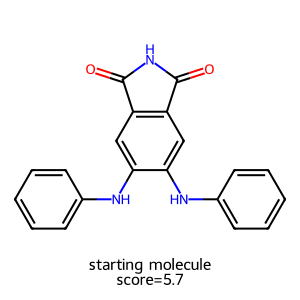

In [10]:
starting_mol = 'C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1'
starting_score = scorer.score([Chem.MolFromSmiles(starting_mol)])[0]
dm.to_image(starting_mol, legends=[f'starting molecule\nscore={starting_score:.1f}'])

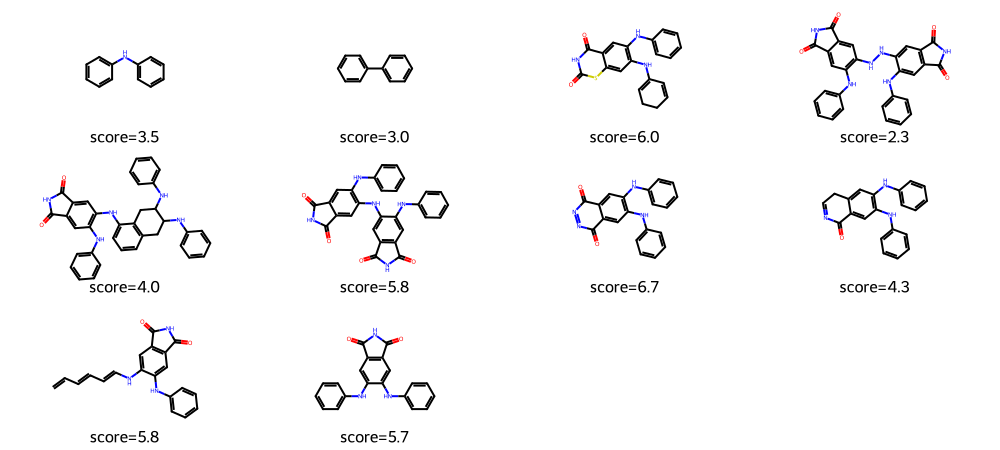

In [11]:
from mol_ga import default_ga
f = lambda mols: [1 for i in mols]  # same score for all molecules (for unguided generation)
neighbors = default_ga(
    starting_population_smiles=[starting_mol],
    scoring_function=f,
    max_generations=1,
    offspring_size=11,
)

# Show generated molecules with our EGFP score
generated_mols = [m[1] for m in neighbors.population]
legends = [f'score={s:.1f}' for s in scorer.score(generated_mols)]
dm.to_image(generated_mols, n_cols=4, mol_size=(250, 150), legends=legends)

We created local variants of the molecule. This unguided generation could, by chance, lead to higher scored molecules than our starting candidate, but this is highly inefficient. A better approach is to repeat this local variation generation process over many generations. At each generation, we can filter for the best $N$ molecules to become the starting population of the next iteration. This is the approach followed by Genetic Algorithms, and it allows us to gradually start creating better and better molecules:

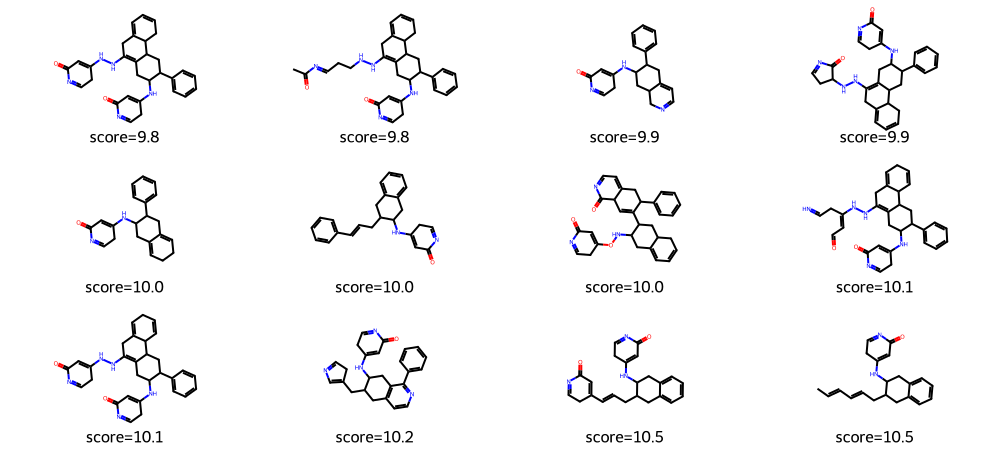

In [12]:
import joblib
from mol_ga import default_ga

# We can start with just a cycle, but it could be beneficial to use strong starting points
# TODO: start from a list of known EGFR binders
starting_smiles = ['C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1']

# Run GA with fast parallel generation
with joblib.Parallel(n_jobs=2) as parallel:
    ga_results = default_ga(
        starting_population_smiles=starting_smiles,
        scoring_function=scorer.score,
        max_generations=20,
        offspring_size=64,
        parallel=parallel,
    )

# Show the best molecules
top = sorted(ga_results.population)[-12:]
dm.to_image([i[1] for i in top], legends=[f'score={i[0]:.1f}' for i in top], n_cols=4, mol_size=(250, 150))

Now this seems to be working much better! With this simple method, we generated molecules with much higher scores than we started with.

However, you'll notice that these molecules all look fairly similar to one another. This is a known problem in MCMC-like approaches. In short, since we are exploring by local-search, traversing regions of the chemical space with lower score in order to get to a more promising starting point gets exponentially less likely the further these "good regions" are from one another.

In the next section, we'll try to alleviate this issue with a more modern twist on generating molecular graphs.

# Part 2: Exploring `gflownet` for fragment-based molecular design


GFlowNets, or generative flow networks, are a class of energy-based models that work well on discrete combinatorial problems, like generating molecules. In other words, instead of randomly editing molecules and filtering them by score, we will train a model that gets rewarded for producing molecules with a high score. GFlowNets have built-in mechanisms for diversity, making them a more efficient way to more explore the chemical space.

The main idea behind GFlowNet is to interpret the DAG (Directed Acyclic Graph) of possible constructions of an object as a **flow network**, and to think of each edge in that DAG as a pipe through which some amount of water, or particles, _flows_. We then want to _find_ a flow where, (a) flow is preserved, (b) the flow coming into a terminal state (a finished object) is equal to its reward (every non-terminal state has a reward of 0).

(Note: the word "network" in GFlowNet refers to the DAG, not to a _neural_ network architecture like the "Net" in "ConvNet" -- naming is hard 😉)

### The GFlowNet Objectives

A central finding of the [first GFlowNet paper](https://arxiv.org/abs/2106.04399) is that if we assign to each edge a _flow_ $F(s,s')>0$, and that this flow respects the following property:
$$\forall s', \sum_{s: (s,s')\in G} F(s,s') = \sum_{s'':(s',s'')\in G} F(s',s'')$$
which ensures _flow consistency_ (i.e. the inward flow to a node should match the outward flow from that node; the outward flow from a terminal node is the reward $R(x)$ ) and define the following policy:
$$P_F(s'|s) = \frac{F(s, s')}{\sum_{s''}F(s, s'')}$$
and sample trajectories (paths through the DAG) using this policy, we will sample terminal states (finished objects $x$) with probability:
$$p(x) \propto R(x)$$

Another point of view we can adopt is to think of the flow of a _trajectory_ $\tau$. If you think of all the possible paths from $s_0$ the initial state to some state $s$, they can all be "assigned" some amount of flow (just like we "assigned" flows to edges earlier). Just like we wanted all incoming flows to a terminal state to be equal to its reward $R(x)$, we can say we want all the trajectory flows that go to a state to equal its reward. More generally we can write
$$F(s) = \sum_{\tau, s\in\tau} F(\tau)$$

Let's also write the probability of a particular trajectory as the product of its policy steps:
$$P(\tau) = \prod_{(s,s') \in \tau} P_F(s'|s) =\frac{1}{Z}F(\tau)$$
we note the relationship of $P(\tau)$ with $F(\tau)$: "what fraction of the total flow $Z$ goes through $\tau$?".

Yet another equivalent point of view we can adopt is to think of _backward_ trajectories. We can define $P_B$ as a distribution over the parents of a state, with the following property

$$P(\tau) = \prod_{(s,s') \in \tau} P_B(s|s')$$

By equating the probability of a trajectory $\tau=(s_0,...,s_n=x)$ using the backward policy to that same probability using the forward policy, we end up with this equality:


$$Z \prod_{t} P_F(s_{t+1}|s_t) = R(x)\prod_t P_B(s_t|s_{t+1})$$

Taking the log and squaring the difference of both sides yields the **Trajectory Balance** objective, which we'll use in this lab.

For more general introductions to GFlowNets, check out the following:
- The 2023 [GFlowNet workshop](https://gflownet.org) has several introductory talks and colab tutorials.
- This high-level [GFlowNet colab tutorial](https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR) (updated versions of which were written for the 2023 workshop, in particular for continuous GFNs).

In paricular for this lab we'll use Recursion's [`gflownet`](https://github.com/recursionpharma/gflownet) library, which implements all both the definition of the DAG and the training objectives for us.

## Fragment-based design

Let's start by explaining fragment-based design. To build a molecule, we can describe it atom-by-atom, or we can reuse common molecular subgraphs, and like lego blocks assemble them together to form a full molecule. There is a large number of methods that can generate fragments, for this tutorial, we went ahead and ran a variant of [BRICS](https://pubmed.ncbi.nlm.nih.gov/18792903/) on Chembl to obtain 50 common fragments.

The list below matches each fragment's SMILES string (e.g. `'c1cn[nH]c1'`) with the atoms to which the fragment can be attached to other fragments (e.g. `[0, 1, 3, 4]`).

In [13]:
# Fragments
chembl_fragments = [
 ('Cl', [0]),
 ('c1ccccc1', [0, 1, 2, 3, 4, 5]),
 ('N', [0]),
 ('c1ccc2ncccc2c1', [0, 1, 2, 5, 6, 7, 9]),
 ('C#N', [0]),
 ('O', [0]),
 ('CC', [0, 1]),
 ('NC=O', [0, 1]),
 ('C=C', [0, 1]),
 ('C', [0]),
 ('CNC', [1]),
 ('c1ccc2scnc2c1', [0, 1, 2, 5, 8]),
 ('c1ccc2[nH]cnc2c1', [0, 1, 2, 4, 5, 8]),
 ('c1cn[nH]c1', [0, 1, 3, 4]),
 ('O=[NH+][O-]', [1]),
 ('C1COCCN1', [0, 1, 3, 4, 5]),
 ('c1cncnc1', [0, 1, 3, 5]),
 ('S', [0]),
 ('c1nnc[nH]1', [0, 3, 4]),
 ('C1CC1', [0, 1, 2]),
 ('CNC=O', [0, 2]),
 ('F', [0]),
 ('C=O', [0]),
 ('O=C1c2ccccc2C2NCCN12', [8, 9]),
 ('FC(F)F', [1]),
 ('C1CNCCN1', [0, 1, 2, 3, 4, 5]),
 ('c1ccc2c(c1)CN1CCN=C21', [0, 1, 2, 5, 6, 9]),
 ('c1nncs1', [0, 3]),
 ('c1ccc2ncncc2c1', [0, 1, 2, 5, 7, 9]),
 ('Br', [0]),
 ('c1ccsc1', [0, 1, 2, 4]),
 ('O=S=O', [1]),
 ('CCC', [1]),
 ('c1cnc2c(c1)CCO2', [0, 1, 5, 7]),
 ('c1ccncc1', [0, 1, 2, 4, 5]),
 ('C1CCNCC1', [0, 1, 2, 3, 4, 5]),
 ('O=C1CCCN1', [2, 3, 4, 5]),
 ('C=C(C#N)C#N', [0]),
 ('O=C1[CH]NC[CH]N1', [2, 3, 4, 5]),
 ('O=CO', [1]),
 ('[CH]NC=O', [0, 2]),
 ('c1ccc2[nH]ccc2c1', [0, 1, 2, 4, 5, 6, 8]),
 ('CO', [0, 1]),
 ('O=C1[CH]CCN1', [2, 3, 4, 5]),
 ('[CH]C', [0]),
 ('[CH]O', [0]),
 ('CN', [0, 1]),
 ('O=C1NC[CH][CH]Oc2ccccc21', [2, 4, 5, 8, 10]),
 ('I', [0]),
 ('c1cscn1', [0, 1, 3])]

Let's visualise our fragment library.

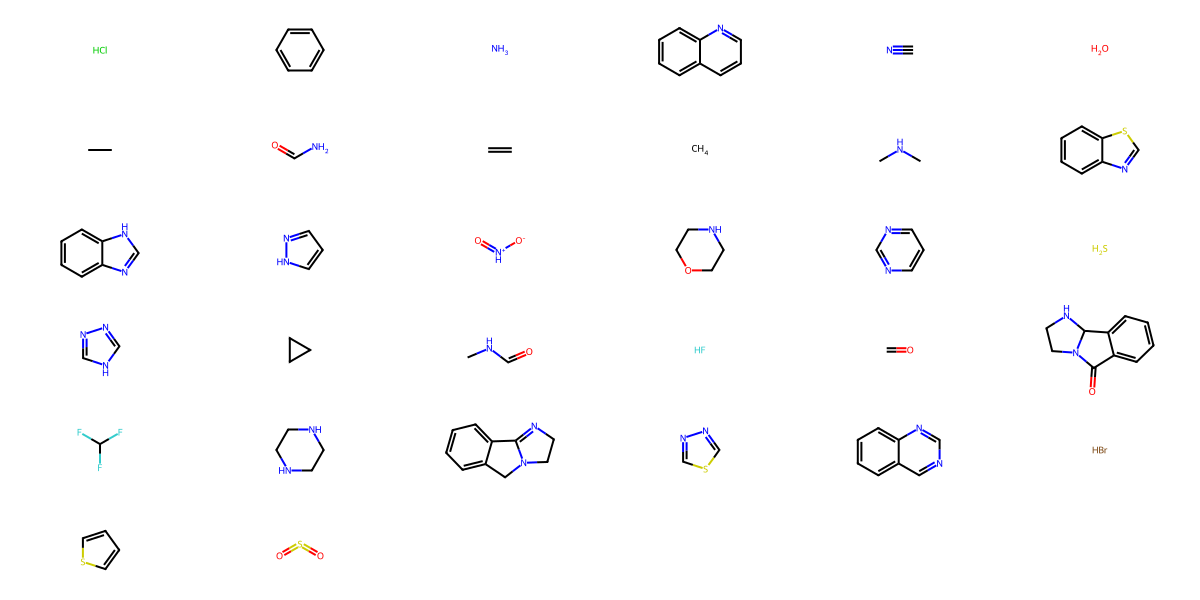

In [14]:
dm.to_image([i[0] for i in chembl_fragments], n_cols=6, mol_size=(200, 100))

Now that we have a fragment library, let's import the things we need to start building!

In [15]:
import torch
import gflownet
from gflownet.config import init_empty, Config
from gflownet.models.graph_transformer import GraphTransformerGFN
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext
from gflownet.algo.trajectory_balance import TrajectoryBalance

In the next cell we will initialize the basic blocks we need and simply use default values for most options:
- the `Config` is where hyperparameters are set (e.g. number of GNN layers, log directory, and so on)
- the `GraphBuildingEnv` is an high-level, agnostic, graph-handling environment (it does not care what the graphs represent, could be a causal graph, a molecular graph, etc.)
- the `-Context` class defines an "implementation" of the environment, this is where we specify what the graphs represent (in this case graphs of molecular fragments)
- the model, is our main model; for GFlowNet it can output $P_F$, $F(s)$ or even $\log Z$
- the `algo`, `TrajectoryBalance`, defines how to (a) sample a model (b) construct a training batch and (c) train a model

In [20]:
torch.manual_seed(1)  # For demonstration purposes

# Let's also set a few config values
cfg = Config()
cfg.model.num_layers = 4
cfg.model.num_emb = 64  # we don't need a big model

# And instantiate the rest
env = GraphBuildingEnv()
ctx = FragMolBuildingEnvContext(fragments=chembl_fragments, max_frags=5)  # setting the maximum number of nodes in our graph to 5
model = GraphTransformerGFN(ctx, cfg)
algo = TrajectoryBalance(env, ctx, cfg)

Let's load CUDA if we can:

In [21]:
if torch.cuda.is_available():
    from gflownet.utils.misc import set_main_process_device
    model.cuda()
    dev = torch.device('cuda')
    set_main_process_device(dev)
else:
    dev = torch.device('cpu')
dev

device(type='cuda')

Now, let's sample our model to see what comes out.

In [22]:
trajs = algo.create_training_data_from_own_samples(model, 4)  # Sample 4 trajectories

A trajectory contains a few things of interest:

In [24]:
list(trajs[0].keys())

['traj',
 'reward_pred',
 'is_valid',
 'is_sink',
 'fwd_logprob',
 'bck_logprob',
 'bck_logprobs',
 'result',
 'bck_a']

We can take a look at the 'traj' key, which contains the sequence of states and actions forming the trajectory:

In [ ]:
for state, action in trajs[0]['traj']:
    print(state, action)

<[], [], []> <GraphActionType.AddNode, 0, 36>
<[0], [], [36]> <GraphActionType.AddNode, 0, 11>
<[0, 1], [(0, 1)], [36, 11]> <GraphActionType.AddNode, 0, 43>
<[0, 1, 2], [(0, 1), (0, 2)], [36, 11, 43]> <GraphActionType.AddNode, 2, 49>
<[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [36, 11, 43, 49]> <GraphActionType.AddNode, 2, 9>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 2, 3, dst_attach, 1>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 0, 1, dst_attach, 0>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 2, 3, src_attach, 2>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 0, 2, dst_attach, 1>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 0, 1, src_attach, 2>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36

Notice here that, since we produce a fragment graph in the form of a junction tree, the only actions the agent is allowed to perform are `AddNode` (attach a new fragment node to an existing node), and `SetEdgeAttr` (in the fragment case, set which atom in the fragment molecule is used in the bond). It can also end the trajectory by using the `Stop` action.

Let's see what's being produced (i.e. the 'result'). We can do so by asking the Context class to map our abstract `Graph`s back to whatever object type the context deals with (in this case, rdkit molecules).

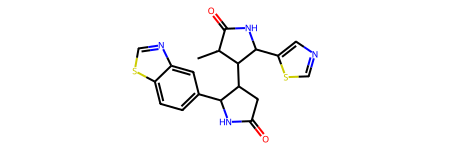

In [25]:
mol = ctx.graph_to_obj(trajs[0]['result'])
mol

This is great, we can already produce molecules! However, to train our GFlowNet to produce *good* molecules, we're going to need a reward function.

In this library, reward functions are defined in a `Task`. A task defines not only the reward function, but also is able to handle things like distributions of conditional information. For simplicy, let's reuse an existing task (the task the GFlowNets were developed for, `SEHTask`, which rewards molecules with a high binding affinity to the sEH protein) and subclass it to make our own:

In [27]:
from gflownet.tasks.seh_frag import SEHTask

class EGFRTask(SEHTask):
  def compute_obj_properties(self, mols):
    is_valid = torch.ones(len(mols)).bool()  # We could make some molecules "invalid", but we'll skip that for today
    return scorer.score(mols).clip(1e-4).reshape((-1, 1)), is_valid  # Clip to make sure the score is positive

task = EGFRTask(cfg)

We can now ask the task to compute rewards; note that we first have to convert the graphs into objects (molecules here).

(Note: we also have to specify the `beta` conditional. In `SEHTask` the model is trained to sample molecules with a probability proportional to $\hat{R} = R(x)^\beta$. In our gigantic state space, many molecules will have a low reward while only a rare few will have higher rewards. This inverse temperature parameter $\beta$ allows the model to be "greedier" and better focus on the high reward molecules.)

In [28]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(4)}, obj_props)

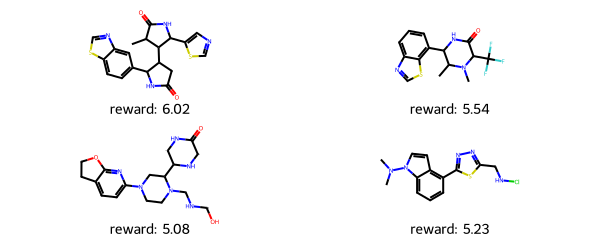

In [29]:
dm.to_image(objs, n_cols=2, mol_size=(300, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards])

We have molecules, we have rewards, we can now train the model!

For this we have to construct a training batch from the trajectories. `TrajectoryBalance` will then compute the loss based on it (and based on the `Config` we gave it).

In [30]:
batch = algo.construct_batch(trajs, cond_info=None, log_rewards=log_rewards).to(dev)
loss, info = algo.compute_batch_losses(model, batch)
loss

tensor(464.8176, device='cuda:0', grad_fn=<AddBackward0>)

We have a loss, we're almost there, just missing an optimizer.

In [31]:
opt = torch.optim.Adam(model.parameters(), 3e-4)

In [32]:
loss.backward()
opt.step()
opt.zero_grad()

Cool! We've trained our model on 4 trajectories.

Let's see if we can do a bit more. In particular, let's train our model with a larger $\beta$ to get it to be a bit greedy.

In [33]:
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 48
losses = []
avg_rewards = []
for i in tqdm(range(100)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model, n=64)

        objs = [ctx.graph_to_obj(i['result']) for i in trajs]
        obj_props, _ = task.compute_obj_properties(objs)
        log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs)) * beta}, obj_props)

    batch = algo.construct_batch(trajs, cond_info=None, log_rewards=log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model, batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses.append(loss.item())
    avg_rewards.append((log_rewards / beta).exp().mean().item())

  0%|          | 0/100 [00:00<?, ?it/s]

What does this look like? Are we learning anything interesting within 100 steps?

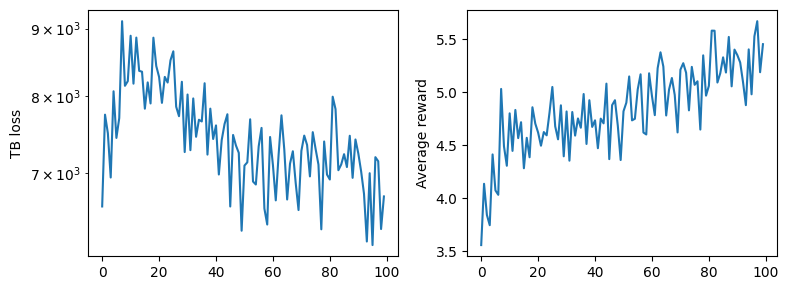

In [34]:
import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 2, figsize=(8,3))
ax[0].plot(losses)
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot(avg_rewards)
ax[1].set_ylabel('Average reward')
pp.tight_layout()

Seems like the average reward is going up, and the loss is kinda going down (it's normal for it to not immediately go down in GFlowNets, exploration causes model a few surprises). Good signs!

We can look again at the generated molecules. They look nice. (and quite diverse)

In [35]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)

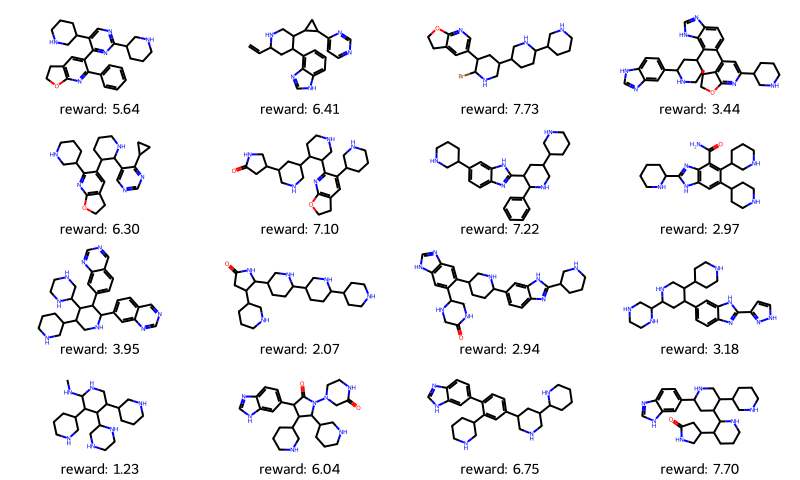

In [36]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(objs[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:16]])

That's it for GFlowNets, just a quick walkthrough of the library and a simple fragment-based hello world! Obviously we can get more diverse and better scoring molecules by training a bigger model, for longer, to leave it the time to explore the space (here we generated 64 * 100 = 6.4k molecules, a typical training run would instead produce from 1 to 10M molecules). Importantly, a GFlowNet allows to amortize the mixing cost from modes to modes throughout the entire training, leaving us with a model at test time that can be used to _quickly_ sample from many modes!

#### To go further, take a look at:

**Some interesting config flags**

There's a plethora of flags in the library, and while they are documented (in `config.py` files), here are some relevant ones.

Algorithm flags
- `algo.illegal_action_logreward`, this acts as both the log-reward for "illegal actions" (which are impossible in many environments) and the minimum possible log-reward. The default of `-100` is easily attained if `beta` is high enough, e.g. for `beta=64`, this corresponds to a minimum reward of $0.21$.
- `algo.train_random_action_prob`, a commonly used setting in GFlowNet is to take some actions at random which a small chance (e.g. $0.1$ or $0.01$) during training to encourage exploration.
- `algo.sampling_tau`, another [common trick](https://arxiv.org/abs/2310.19685) is to maintain a delayed set of parameters which are used to sample new trajectories, updated as $\theta' \leftarrow \tau\theta' + (1-\tau)\theta$ after every gradient step. Typical useful values are in $[0.9,0.99]$

GFN/TB flags
- `algo.tb.do_parameterize_p_b`, the default $P_B$ is the uniform policy. Turn this flag on to instead learn it.
- `algo.tb.variant`, the library implements `TB`, `SubTB1`, and `DB` (flow matching is a separate class)
- `algo.tb.do_correct_idempotent`, (warning, expensive!) activating this flag makes sure that [different actions that lead to the same state](https://openreview.net/forum?id=CZGHAeeBk3) are counted together appropriately.

Replay flags:
- `replay.use`, flag to turn replay on or off
- `replay.capacity`, the capacity of the Replay Buffer (for now, RBs are FIFO)
- `replay.warmup`, the number of initial samples to draw before starting to train

**Making the best of your GPU**

As alluded to above, a main bottleneck in training GFlowNets is the _sampling_ of new trajectories. This requires doing "small" forward passes over and over to compute $P_F$, sampling actions, and taking environment steps. This also involves lots of CPU computation, which would normally keep the GPU unused. This library distributes this CPU work in workers in a fairly transparent way. Using a `GFNTrainer` sets this up for you! **All that needs to be done is to set `cfg.num_workers` to an appropriate value.**

Another (unfortunately) important choice is to decide how workers should communicate with each other. From fastest to slowest (but least to most convenient):
- Using shared buffers; requires setting `cfg.mp_buffer_size` to the number of bytes to use (~per worker) to create those fixed buffers.
- Using pickle; (un)surprisingly, torch is bad at transferring lots of small tensors, and so a valid strategy is to set `cfg.pickle_mp_messages = True`.
- Doing nothing; this relies on torch's internal serialization and memory sharing mechanisms, which are really not optimized for our use case but can handle anything.

Finally, another big factor in GPU usage is batch size. YMMV, but generally speaking the larger batch size that can be made to fit in GPU memory, the better.

## Extra: atom-graph design

Note: If you want to learn more about the `gflownet` library, check out an expanded version of this notebook [here](https://colab.research.google.com/drive/1wANyo6Y-ceYEto9-p50riCsGRb_6U6eH).

In what follows we'll use the same task, but instead of using fragments, we'll use `gflownet` to directly generate the atom graph. You may find that this is harder ;)

We'll also make use of the `Trainer` class of the library to make our life easier.

In [ ]:
from typing import Dict, List, Tuple
import torch
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor

# Config stuff
from gflownet.config import Config, init_empty
# This is our per-atom-generation environment
from gflownet.envs.mol_building_env import MolBuildingEnvContext

# This is the basic GFN trainer that we'll reuse for our purposes
from gflownet.online_trainer import StandardOnlineTrainer

class AtomEGFRTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        # Here we choose some specific parameters, in particular, we don't want
        # molecules of more than 25 heavy atoms, so we set
        cfg.algo.max_nodes = 25

        # This creates a lagged sampling model, see https://arxiv.org/abs/2310.19685
        cfg.algo.sampling_tau = 0.9

        # It is possible that our GFN generates impossible molecules. This will be
        # their logreward:
        cfg.algo.illegal_action_logreward = -100
        # Disable random actions
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0

    def setup_task(self):
        # The task we created above
        self.task = EGFRTask(self.cfg)

    def setup_env_context(self):
        # The per-atom generation context
        self.ctx = MolBuildingEnvContext(
            ["C", "F", "S", "O", "N", "Cl"],
            charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            num_rw_feat=0,  # disable random-walk features
            max_nodes=self.cfg.algo.max_nodes,  # Limit the number of atoms
            num_cond_dim=self.task.num_cond_dim,
        )


We can now run the setup like this:

In [ ]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./log_dir_atom"
config.overwrite_existing_exp = True
config.device = dev
config.num_training_steps = 10
config.num_workers = 2
config.num_validation_gen_steps = 1

trial = AtomEGFRTrainer(config, print_config=False)
trial.run()

11/06/2024 14:48:12 - INFO - logger - Starting training


INFO:logger:Starting training
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


11/06/2024 14:48:24 - INFO - logger - iteration 1 : offline_loss:0.00 online_loss:1405.85 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:1405.85 n_loss:0.00 tb_loss:1405.85 batch_entropy:35.05 traj_lens:11.89 grad_norm:921.35 grad_norm_clip:76.47 sampled_reward_avg:0.97 train_time:0.44 time_spent:12.17


INFO:logger:iteration 1 : offline_loss:0.00 online_loss:1405.85 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:1405.85 n_loss:0.00 tb_loss:1405.85 batch_entropy:35.05 traj_lens:11.89 grad_norm:921.35 grad_norm_clip:76.47 sampled_reward_avg:0.97 train_time:0.44 time_spent:12.17


11/06/2024 14:48:32 - INFO - logger - iteration 2 : offline_loss:0.00 online_loss:1879.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:1879.70 n_loss:0.00 tb_loss:1879.70 batch_entropy:63.95 traj_lens:19.67 grad_norm:1914.59 grad_norm_clip:81.96 sampled_reward_avg:1.20 train_time:0.27 time_spent:7.63


INFO:logger:iteration 2 : offline_loss:0.00 online_loss:1879.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:1879.70 n_loss:0.00 tb_loss:1879.70 batch_entropy:63.95 traj_lens:19.67 grad_norm:1914.59 grad_norm_clip:81.96 sampled_reward_avg:1.20 train_time:0.27 time_spent:7.63


11/06/2024 14:48:37 - INFO - logger - iteration 3 : offline_loss:0.00 online_loss:1895.10 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.02 loss:1895.10 n_loss:0.00 tb_loss:1895.10 batch_entropy:48.24 traj_lens:15.47 grad_norm:1625.47 grad_norm_clip:80.64 sampled_reward_avg:1.50 train_time:0.29 time_spent:5.47


INFO:logger:iteration 3 : offline_loss:0.00 online_loss:1895.10 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.02 loss:1895.10 n_loss:0.00 tb_loss:1895.10 batch_entropy:48.24 traj_lens:15.47 grad_norm:1625.47 grad_norm_clip:80.64 sampled_reward_avg:1.50 train_time:0.29 time_spent:5.47


11/06/2024 14:48:47 - INFO - logger - iteration 4 : offline_loss:0.00 online_loss:1759.86 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:1759.86 n_loss:0.00 tb_loss:1759.86 batch_entropy:52.45 traj_lens:16.97 grad_norm:1425.29 grad_norm_clip:81.10 sampled_reward_avg:1.32 train_time:0.47 time_spent:10.10


INFO:logger:iteration 4 : offline_loss:0.00 online_loss:1759.86 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:1759.86 n_loss:0.00 tb_loss:1759.86 batch_entropy:52.45 traj_lens:16.97 grad_norm:1425.29 grad_norm_clip:81.10 sampled_reward_avg:1.32 train_time:0.47 time_spent:10.10


11/06/2024 14:48:53 - INFO - logger - iteration 5 : offline_loss:0.00 online_loss:1936.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.04 loss:1936.58 n_loss:0.00 tb_loss:1936.58 batch_entropy:60.47 traj_lens:18.73 grad_norm:2105.21 grad_norm_clip:81.34 sampled_reward_avg:1.44 train_time:0.30 time_spent:6.30


INFO:logger:iteration 5 : offline_loss:0.00 online_loss:1936.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.04 loss:1936.58 n_loss:0.00 tb_loss:1936.58 batch_entropy:60.47 traj_lens:18.73 grad_norm:2105.21 grad_norm_clip:81.34 sampled_reward_avg:1.44 train_time:0.30 time_spent:6.30


11/06/2024 14:49:06 - INFO - logger - iteration 6 : offline_loss:0.00 online_loss:1862.19 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.06 loss:1862.19 n_loss:0.00 tb_loss:1862.19 batch_entropy:70.05 traj_lens:21.50 grad_norm:2075.01 grad_norm_clip:81.34 sampled_reward_avg:1.74 train_time:0.47 time_spent:12.50


INFO:logger:iteration 6 : offline_loss:0.00 online_loss:1862.19 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.06 loss:1862.19 n_loss:0.00 tb_loss:1862.19 batch_entropy:70.05 traj_lens:21.50 grad_norm:2075.01 grad_norm_clip:81.34 sampled_reward_avg:1.74 train_time:0.47 time_spent:12.50


11/06/2024 14:49:17 - INFO - logger - iteration 7 : offline_loss:0.00 online_loss:2410.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2410.55 n_loss:0.00 tb_loss:2410.55 batch_entropy:80.09 traj_lens:23.72 grad_norm:3081.20 grad_norm_clip:84.58 sampled_reward_avg:1.69 train_time:0.35 time_spent:11.31


INFO:logger:iteration 7 : offline_loss:0.00 online_loss:2410.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2410.55 n_loss:0.00 tb_loss:2410.55 batch_entropy:80.09 traj_lens:23.72 grad_norm:3081.20 grad_norm_clip:84.58 sampled_reward_avg:1.69 train_time:0.35 time_spent:11.31


11/06/2024 14:49:24 - INFO - logger - iteration 8 : offline_loss:0.00 online_loss:2713.64 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2713.64 n_loss:0.00 tb_loss:2713.64 batch_entropy:68.24 traj_lens:20.72 grad_norm:1520.25 grad_norm_clip:80.08 sampled_reward_avg:1.68 train_time:0.52 time_spent:6.54


INFO:logger:iteration 8 : offline_loss:0.00 online_loss:2713.64 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2713.64 n_loss:0.00 tb_loss:2713.64 batch_entropy:68.24 traj_lens:20.72 grad_norm:1520.25 grad_norm_clip:80.08 sampled_reward_avg:1.68 train_time:0.52 time_spent:6.54


11/06/2024 14:49:45 - INFO - logger - iteration 9 : offline_loss:0.00 online_loss:2796.44 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.10 loss:2796.44 n_loss:0.00 tb_loss:2796.44 batch_entropy:97.85 traj_lens:28.55 grad_norm:2453.30 grad_norm_clip:82.82 sampled_reward_avg:2.07 train_time:0.41 time_spent:20.84


INFO:logger:iteration 9 : offline_loss:0.00 online_loss:2796.44 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.10 loss:2796.44 n_loss:0.00 tb_loss:2796.44 batch_entropy:97.85 traj_lens:28.55 grad_norm:2453.30 grad_norm_clip:82.82 sampled_reward_avg:2.07 train_time:0.41 time_spent:20.84


11/06/2024 14:49:45 - INFO - logger - iteration 10 : offline_loss:0.00 online_loss:2445.62 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.12 loss:2445.62 n_loss:0.00 tb_loss:2445.62 batch_entropy:82.16 traj_lens:24.09 grad_norm:2352.29 grad_norm_clip:81.56 sampled_reward_avg:1.78 train_time:0.35 time_spent:0.46


INFO:logger:iteration 10 : offline_loss:0.00 online_loss:2445.62 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.12 loss:2445.62 n_loss:0.00 tb_loss:2445.62 batch_entropy:82.16 traj_lens:24.09 grad_norm:2352.29 grad_norm_clip:81.56 sampled_reward_avg:1.78 train_time:0.35 time_spent:0.46


In [ ]:
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 16, torch.ones((16, trial.ctx.num_cond_dim)))

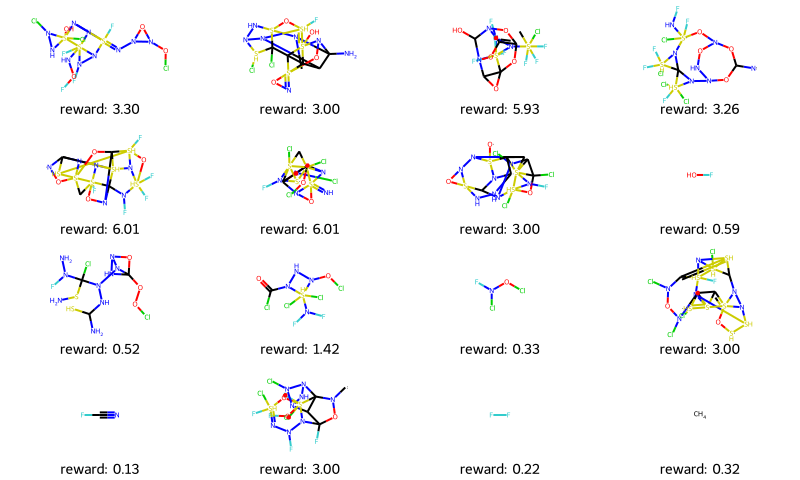

In [ ]:
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
MolsToGridImage(objs, molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:16]])

These are pretty horrible molecules! As a future exercice, you could try to make these look better.

Note: why do these molecules look so much worse than GraphGA's? GraphGA encodes lots of chemical priors in its mutation steps, this allows the method to produce "good looking" molecules without too much effort. As it is, the task and GFlowNet model do not encode such priors in any ways, and so the model is rewarded for producing "nonsense". This is a fairly hard challenge within atom-based design.

Because we've used `gflownet`'s `Trainer`s to run this, the results are logged for us:

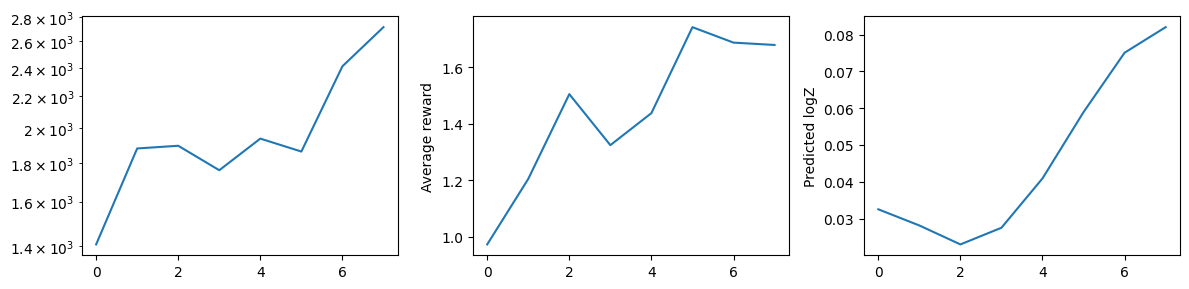

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = 'log_dir_atom'
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

In [ ]:
import importlib
import gflownet.utils.sqlite_log as sqll
importlib.reload(sqll)
results = sqll.read_all_results('./log_dir_atom/train/')
results

,smi,r,fr_0,ci_beta
0,SC1NNO1,0.000100,0.000100,17.787626
1,OC1(OF)S2=NN3C4(CC5=[SH]3(F)ONC51O4)C(F)[SH](C...,2.434799,2.434799,13.636193
2,C=S(Cl)(Cl)=C(F)Cl,1.123119,1.123119,23.190222
3,[C]#[SH](NN(F)S)C1(Cl)NOO1,3.465696,3.465696,23.028465
4,FN(Cl)ON(Cl)N(F)N(Cl)NCl,0.000100,0.000100,19.487047
...,...,...,...,...
635,C[SH]12=S34(N=S5(NCl)=S367ON6OS[SH](O)[SH]4OS5...,6.009729,6.009729,18.057117
636,O=C1OS(F)(Cl)[SH]1Cl,1.141907,1.141907,8.313057
637,O=NON1N(F)[S]123NN1C(F)(NOS(O)(N2)[SH2]3)N2N3C...,2.565790,2.565790,27.607363
638,FCl,0.476854,0.476854,23.401894


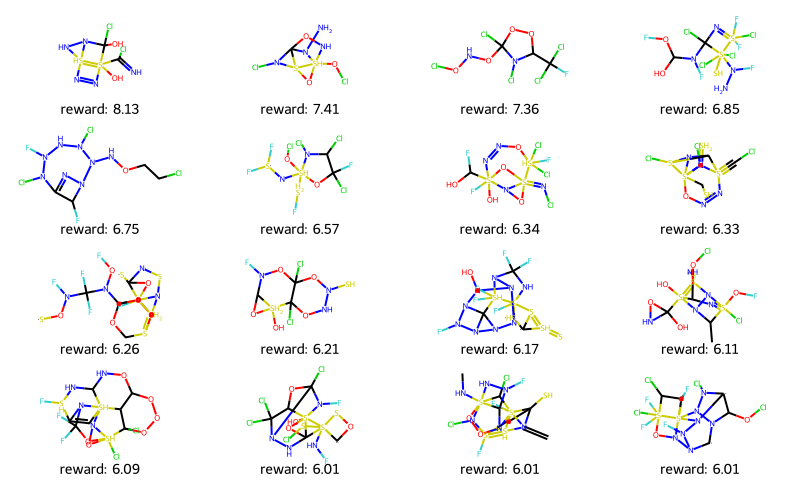

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
top_k = np.argsort(results['r'])[-16:][::-1]
rewards = results['r'][top_k]
mols = [Chem.MolFromSmiles(i) for i in results['smi'][top_k]]
MolsToGridImage(mols[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

# Part 3: Exploring `safe-gpt` for generating molecules from language modeling



In [40]:
# Import the stuff we need
import torch
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from transformers import AutoTokenizer, AutoModel
import safe as sf
import traceback
import datamol as dm

##  SAFE encoding demo

SAFE strings are a special SMILES encoding that also *are* SMILES string. This is done by converting the SMILES string into its graphical representation, running a molecular fragmentation algorithm, and then recombining the SMILES-representation for each fragment into a single string. This yields our SAFE-encoding, a valid SMILES string that can still be fed into any rdkit function, but that is much better suited for language models.

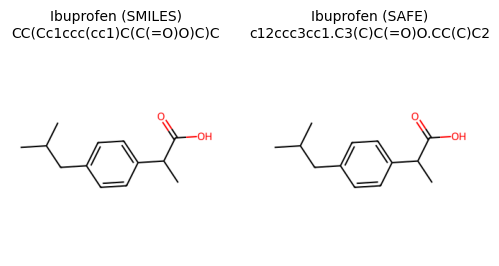

In [41]:
ibuprofen = "CC(Cc1ccc(cc1)C(C(=O)O)C)C"
ibuprofen_sf = sf.encode(ibuprofen)  # c12ccc3cc1.C3(C)C(=O)O.CC(C)C2

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(Draw.MolToImage(Chem.MolFromSmiles(ibuprofen)))
axes[0].set_title(f"Ibuprofen (SMILES)\n{ibuprofen}", fontsize=10)
axes[0].axis("Off")
axes[1].imshow(Draw.MolToImage(Chem.MolFromSmiles(ibuprofen_sf)))
axes[1].set_title(f"Ibuprofen (SAFE)\n{ibuprofen_sf}", fontsize=10)
axes[1].axis("Off")
plt.show()

One of the first advantages is out-of-the-box data-augmentation. The fragments composing the SAFE-encoding can be recombined in any order without altering the nature of the molecule. This means that we can generate a lot of different SAFE-encodings for the same molecule, and use them as different training examples for a language model.

In [78]:
ibuprofen = "CC(Cc1ccc(cc1)C(C(=O)O)C)C"
ibuprofen_sfs = sorted(list(set([sf.encode(ibuprofen, randomize=True) for _ in range(300)])))

celecoxib = "Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1"
celecoxib_sfs = list(set([sf.encode(celecoxib, randomize=True) for _ in range(300)]))

print(f"Number of unique SAFE encodings for ibuprofen ({len(ibuprofen_sfs[0].split('.'))} fragments): {len(ibuprofen_sfs)}")
print(f"Number of unique SAFE encodings for celecoxib ({len(celecoxib_sfs[0].split('.'))} fragments): {len(celecoxib_sfs)}")

Number of unique SAFE encodings for ibuprofen (3 fragments): 6
Number of unique SAFE encodings for celecoxib (4 fragments): 24


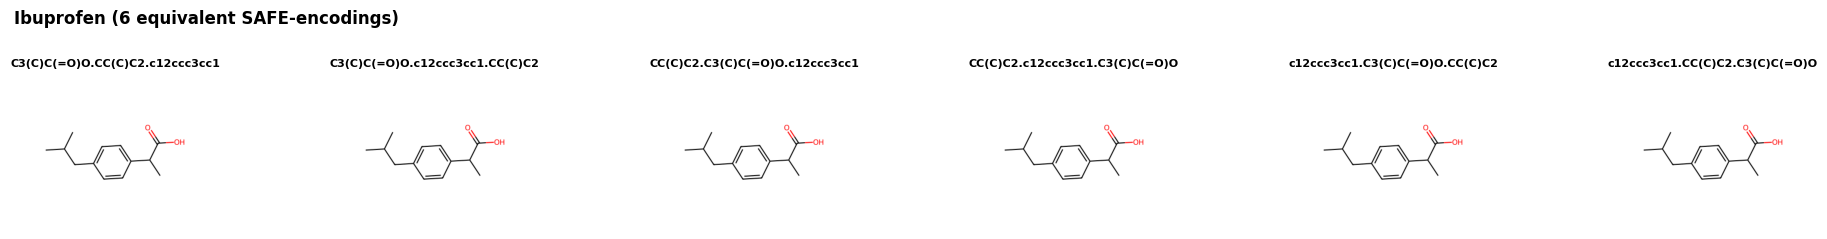

In [79]:
fig, axes = plt.subplots(1, 6, figsize=(20, 2))
fig.text(0.05, 1.1, f"Ibuprofen ({len(ibuprofen_sfs)} equivalent SAFE-encodings)", ha="left", fontsize=12, fontweight="bold")
for i, safe in enumerate(ibuprofen_sfs):
    axes[i].imshow(Draw.MolToImage(Chem.MolFromSmiles(safe)))
    axes[i].axis("Off")
    axes[i].set_title(f"{safe}", fontsize=8, fontweight="bold")

fig.tight_layout()
fig.show()

SAFE fragments are molecules themselves, however, they are not guaranteed to be valid molecules. By using the decoder, we can fix fragments with un-fulfilled attachment points.

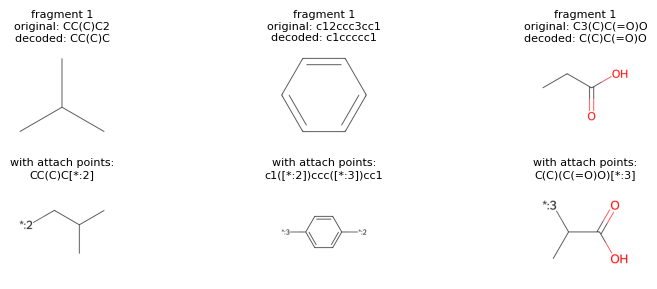

In [43]:
frags = ibuprofen_sfs[3].split('.')

fig, axes = plt.subplots(2, len(frags), figsize=(3 * len(frags), 3))
for i, show_attach_points in enumerate([False, True]):
    for j, frag in enumerate(frags):
        axes[i,j].imshow(Draw.MolToImage(Chem.MolFromSmiles(sf.decode(frag, remove_dummies=not(show_attach_points)))))
        axes[i,j].axis("Off")
        if show_attach_points:
            axes[i,j].set_title(f"with attach points:\n{sf.decode(frag, remove_dummies=not(show_attach_points))}", fontsize=8)
        else:
            axes[i,j].set_title(f"fragment {i+1}\noriginal: {frag}\ndecoded: {sf.decode(frag)}", fontsize=8)

fig.tight_layout()
fig.show()

## Scaffold decoration

Now that we know what SAFE encodings are, we can leverage them to perform scaffold decoration.

Let's start by loading a pre-trained SAFE-GPT model:

In [44]:
designer = sf.SAFEDesign.load_default(verbose=True)
designer.model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

We will use this scaffold:

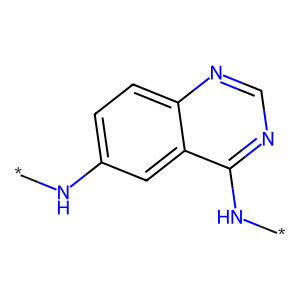

In [45]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"
Draw.MolToImage(Chem.MolFromSmiles(scaffold))

The attachment points denoted by a `*` above will be used as anchoring point for new motifs to be attached. This can be performed out-of-the-box:

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-06-14 01:17:32.950 | INFO     | safe.sample:scaffold_decoration:538 - After sanitization, 24 / 24 (100.00 %)  generated molecules are valid !


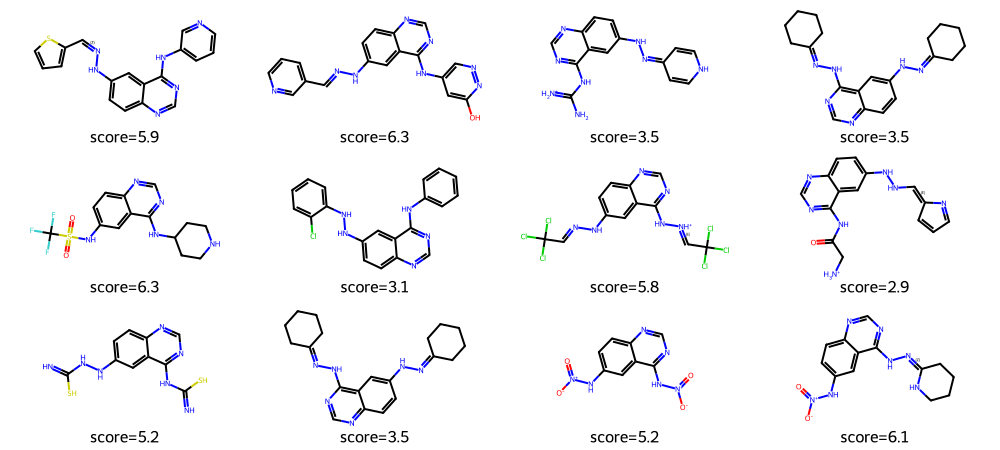

In [49]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)
generated_mols = [dm.to_mol(x) for x in generated_smiles]
scores = scorer.score([Chem.MolFromSmiles(smile) for smile in generated_smiles])
legends = [f"score={score:.1f}" for score in scores]
dm.to_image(generated_mols[:12], legends=legends[:12], n_cols=4, mol_size=(250, 150))
# dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)

We can see how different decoration motifs can drastically affect the score value for the molecules!

What's interesting with scaffold decoration is that it preserves the structure of our core element (the scaffold). This can be useful in lead optimization when we wish to improve the ADME properties of our candidate without altering too much its main function.

This was a short example of SAFE encodings and its application to scaffold decoration, but these encodings allow for many more generative tasks. Check out the [paper](https://arxiv.org/abs/2310.10773) and [github](https://github.com/datamol-io/safe) for more details!

# Conclusion

This conclude this tutorial. We briefly glimpsed at different approaches and libraries for molecular generation, ranging from genetic algorithms to gflownets to language models. Feel free to copy and edit that notebook, and try to take it further by exploring these approaches in more depth, good luck!